













































































































































































































## Vamos a usar la librería "dtaidistance"

https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [1]:
import pandas._libs.testing as _testing
import numpy as np
import pandas as pd
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import matplotlib.pyplot as plt
from datetime import datetime

### VARIABLES DE ENTRADA

In [2]:
## Ruta al archivo donde están los archivos con la data
path_data = "Data_Train/"
## Nombre del archivo donde está la data
file_data = "27f_3m_CL APR23.Last.txt"

## Ruta del archivo donde están los patrones
path_patterns ="Data_Patron/"
## Nombre del archivo donde está el patrón
file_pattern = "Momentum.csv"

# Ruta de los archivos de salida:
path_output = "Output_Train/"
## Nombre del archivo de salida (tanto el csv como el HTML)
nombre_output = "Momentum1"

### Lectura y formateo de la data

In [3]:
def fecha(data, dia):
    data["Date"] = data["ds"].str[0:8]
    data["Date"] = pd.to_datetime(data["Date"], format="%Y%m%d").dt.date
    data["Time"] = data["ds"].str[9:15]
    data["Time"] = pd.to_datetime(data["Time"], format="%H%M%S").dt.time
    data["ds"] = pd.to_datetime(data['Date'].astype(str) + ' ' + data['Time'].astype(str))
    if dia != None:
        data = data[data["ds"].dt.day == dia]
    return data

    
df = pd.read_csv(path_data + file_data, sep=";", names=["ds", "Open", "High", "Low", "Close", "Volume"])
df = fecha(df, None)
df["signo_vela"] = df["Close"] - df["Open"] #si es positivo --> alcista; si negativo --> bajista
df["signo_vela_anterior"] = df["signo_vela"].shift(1).fillna(0)
df.loc[(df["signo_vela_anterior"]<=0) & (df["signo_vela"]>=0), "Price"] = df["High"]
df.loc[(df["signo_vela_anterior"]>=0) & (df["signo_vela"]>=0), "Price"] = df["High"]
df.loc[(df["signo_vela_anterior"]>=0) & (df["signo_vela"]<=0), "Price"] = df["Low"]
df.loc[(df["signo_vela_anterior"]<=0) & (df["signo_vela"]<=0), "Price"] = df["Low"]

<Axes: xlabel='ds'>

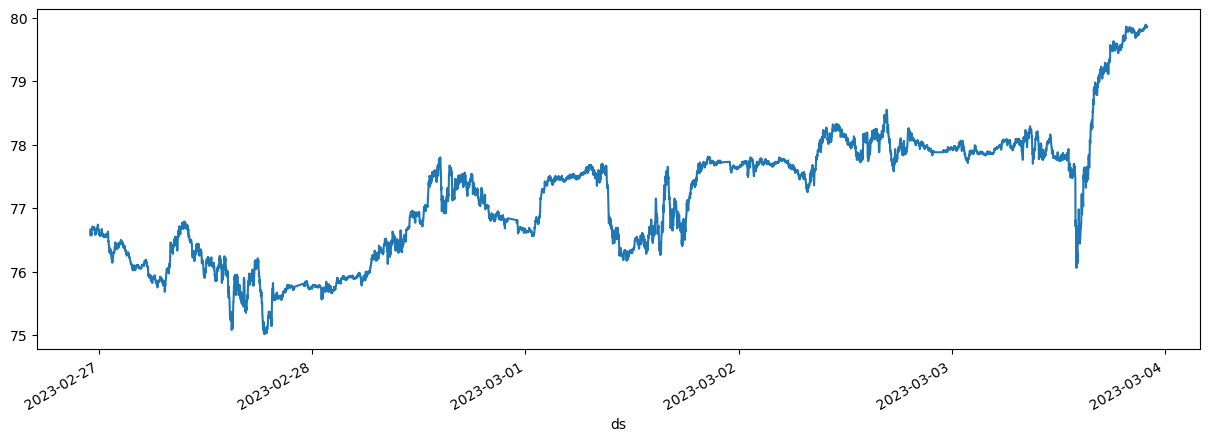

In [4]:
df.set_index("ds")["Close"].plot(figsize=(15,5))

## SCANNER

In [5]:
%%time
def standard_scale(ts):
    return (ts - np.mean(ts))/np.std(ts)

def dtw_distance(x):
    global s1
    x = standard_scale(x)
    distance = dtw.distance_fast(x.values, s1, use_pruning=True)
    return distance

df1 = pd.read_csv(path_patterns + file_pattern, sep=";")
df1.head()

CPU times: total: 0 ns
Wall time: 8.34 ms


,ds,Open,High,Low,Close,Volume,Date,Time,idx,signo_vela,signo_vela_anterior,Price,diferencia_abs
0,2023-03-06T19:18:00,80.19,80.19,80.14,80.18,326,06/03/2023,19:18:00,1215,-0.01,0.00,76.14,0.003280
1,2023-03-06T19:19:00,80.18,80.20,80.15,80.16,305,06/03/2023,19:19:00,1216,-0.02,-0.01,76.17,0.436493
2,2023-03-06T19:20:00,80.16,80.17,80.11,80.17,290,06/03/2023,19:20:00,1217,0.01,-0.02,76.20,-0.091192
3,2023-03-06T19:21:00,80.17,80.25,80.16,80.23,380,06/03/2023,19:21:00,1218,0.06,0.01,76.25,0.148052
4,2023-03-06T19:22:00,80.23,80.25,80.20,80.24,455,06/03/2023,19:22:00,1219,0.01,0.06,76.29,-0.369249


In [6]:
%%time
def standard_scale(ts):
    return (ts - np.mean(ts))/np.std(ts)

def dtw_distance(x):
    global s1
    x = standard_scale(x)
    distance = dtw.distance_fast(x.values, s1, use_pruning=True)
    return distance

df1 = pd.read_csv(path_patterns + file_pattern, sep=";")
s1 = df1["Price"].values
s1 = standard_scale(s1)

df["distance"] = df["Price"].rolling(window=len(s1)+10, center=False).apply(lambda x: dtw_distance(x))  

CPU times: total: 1.34 s
Wall time: 1.87 s


<Axes: >

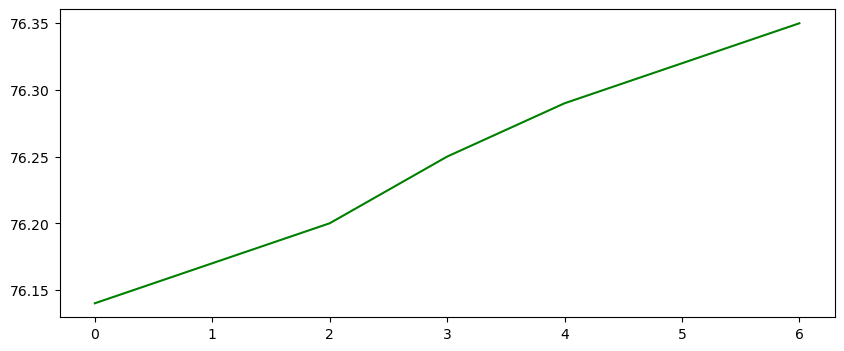

In [7]:
df1["Price"].plot(c="green", figsize=(10,4))

### Establecer el valor máximo de distancia

In [8]:
## Valor límite de distancia por debajo del cual vamos a seleccionar los patrones
maximo = 3.7

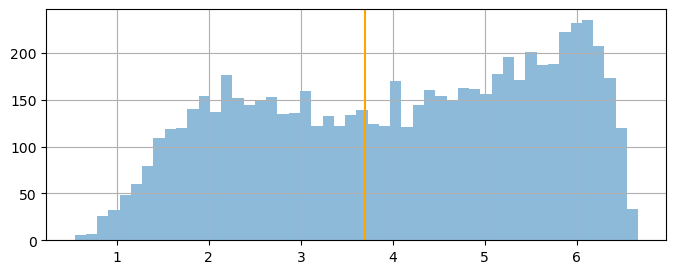

In [9]:
df["distance"].hist(figsize=(8,3), bins=50, alpha=0.5)
plt.axvline(x=maximo, c="orange")

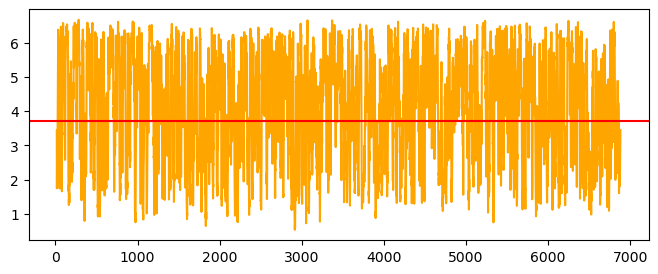

In [10]:
df["distance"].plot(figsize=(8,3), c="orange")
plt.axhline(y=maximo, c="red")

In [11]:
## ATR para asegurarnos zonas con velas suficientemente grandes
df["close_open"] = np.abs(df["Close"] - df["Open"])
df["atr"] = df["close_open"].rolling(window=14).mean()
df["atr"].describe()

count    6868.000000
mean        0.025981
std         0.019322
min         0.002143
25%         0.012143
50%         0.021429
75%         0.035000
max         0.221429
Name: atr, dtype: float64

### Determinamos las entradas

In [12]:
df = df.reset_index(drop = True)
df["filtered"] = False
atr_th = df["atr"].quantile(0.5)


df.loc[(df["atr"]>df["atr"].median()) &\
       (df["distance"]<maximo),
       "filtered"] = True


df["filtered_sum"] = df["filtered"].rolling(window=len(s1), center=False).sum()
df["entrada"] = False
df.loc[(df["filtered_sum"]==1) & (df["filtered"]==True), "entrada"] = True

df.loc[:, 'breakout_region'] = np.where(
        df['entrada'],
        df['High'].max(),
        df['Low'].min()
    )

df["breakout_region"].value_counts()

74.99    6772
79.90     109
Name: breakout_region, dtype: int64

In [13]:
volume_threshold = 250
df.loc[(df["breakout_region"]==df["High"].max()) &\
       (df["Volume"]>=volume_threshold) &\
       ((df["Close"] - df["Open"])>0), "volume_marker"] = df["Close"]

In [14]:
## Genera un archivo csv con todas las columnas calculadas hasta el mommento
## Se le puede poner el nombre que se quiera
now = datetime.now().strftime("%Y%m%d_%H%M%S")
df.to_csv(f"{path_output}{nombre_output}_{now}.csv", sep=";", index=False)

### Creamos el HTML con el gráfico de salida

In [15]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [16]:
def plot_result(df: pd.DataFrame):

    df["color"] = "blue"
    df["color2"] = "brown"
    df.loc[df["entrada"]==True,"color"] = "black"
    df.loc[df["volume_marker"]==df["Close"],"color"] = "red"

    # Create subplots and mention plot grid size
    fig = make_subplots(rows=3, cols=1, shared_xaxes=True, 
                   vertical_spacing=0.05,
                   row_width=[0.2, 0.2, 0.6])

    ## Gráfico con las velas
    fig.add_trace(
        go.Candlestick(
            x = df['ds'],
            open = df['Open'],
            high = df['High'],
            low = df['Low'],
            close = df['Close'],
            showlegend = False,        
        ), row=1, col=1
    )

    # Gráfico con las zonas en verde donde encuentra los patrones
    fig.add_trace(
        go.Scatter(
            x = df['ds'], 
            y = df['breakout_region'],
            fill = 'tonexty',
            fillcolor = 'rgba(0, 236, 109, 0.5)',
            mode = 'lines',
            line = {'width': 2, 'shape': 'hvh','color':'rgba(0, 236, 109, 0.5)'},
            showlegend = False,
        ), row=1, col=1
    )


    # Gráfico de barras con la distancia
    fig.add_trace(go.Bar(x=df['ds'], y=df['distance'], showlegend=False,
                        marker_color=df["color"]), row=2, col=1)
    
    # Marca la flecha en Volumen extremo
    fig.add_trace(
        go.Scatter(
            mode="markers",
            x = df['ds'], 
            y = df['volume_marker']+0.05,
            marker=dict(
                color='rgba(0, 206, 250, 0.5)',
                size=7,
                symbol = "diamond",
                line=dict(
                    color='MediumPurple',
                    width=2
                    )
            ),
            showlegend = False,
        ), row=1, col=1
    )


    # Gráfico de barras con el Volumen
    fig.add_trace(go.Bar(x=df['ds'], y=df['Volume'], showlegend=False,
                        marker_color=df["color2"]), row=3, col=1)

    fig.update_layout(
        yaxis = {'range': [df['Low'].min(), df['High'].max()], 'title': 'Price ($)'},
        yaxis2 = {'range': [0, df['distance'].max()], 'title': 'distance'},
        yaxis3 = {'range': [0, df["Volume"].quantile(0.97)], 'title': 'Volume'})


    fig.update(layout_xaxis_rangeslider_visible=False)



    ## Se crea el HTML con el que "jugar"
    now = datetime.now().strftime("%Y%m%d_%H%M%S")
    fig.write_html(f"{path_output}{nombre_output}_{now}.html")


plot_result(df)